In [1]:
from glob import glob
import cv2
import random
import os
%matplotlib inline
import tensorflow as tf
# sparse_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import matplotlib.pyplot as plt


2024-05-11 05:19:56.957080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 05:19:56.957217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 05:19:57.089510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


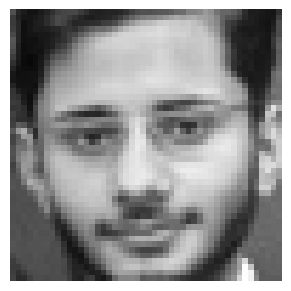

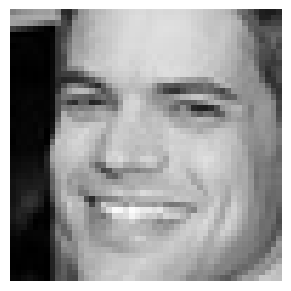

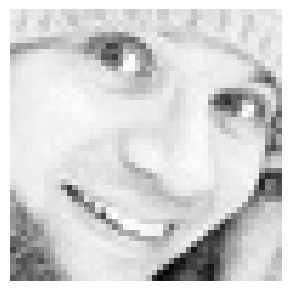

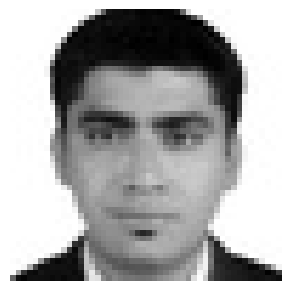

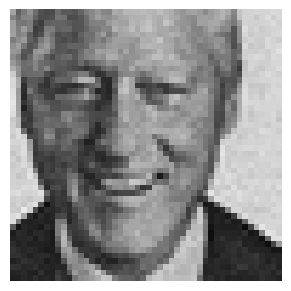

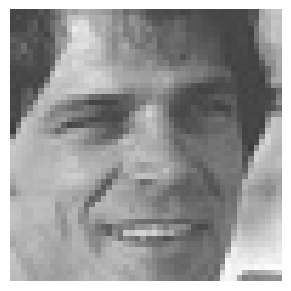

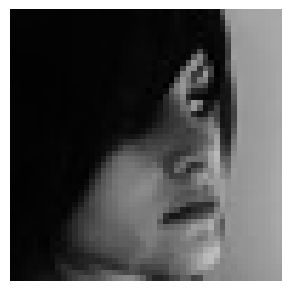

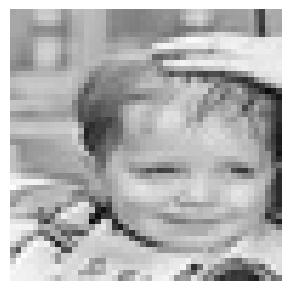

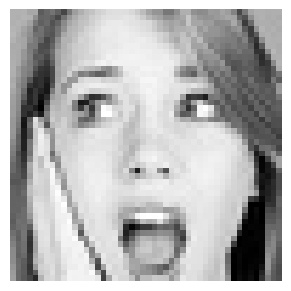

In [2]:
images = glob("/kaggle/input/emotion-detection/train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')


In [3]:
img_size=48
batch_size=64
datagen_train=ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory('/kaggle/input/emotion-detection/train',
                                                  target_size=(img_size,img_size),
                                                  color_mode='grayscale',
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=True)
datagen_validation=ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_train.flow_from_directory('/kaggle/input/emotion-detection/test',
                                                  target_size=(img_size,img_size),
                                                  color_mode='grayscale',
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size= kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    
    return x


In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [6]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=Convolution(inputs,64,(3,3))
    conv_2=Convolution(conv_1,128,(5,5))
    conv_3=Convolution(conv_2,512,(3,3))
    conv_4=Convolution(conv_3,512,(3,3))

    flatten= Flatten()(conv_4)

    dense_1= Dense_f(flatten,256)
    dense_2= Dense_f(dense_1,512)

    output = Dense(7, activation="softmax")(dense_2)
    model = Model(inputs=[inputs],outputs = [output])
    
    opt = Adam(learning_rate=0.0005)
    model.compile(loss=['categorical_crossentropy'], optimizer=opt, metrics=['acc'])
    return model


In [7]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,90

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [8]:
checkpoint = ModelCheckpoint("model.weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)
callbacks = [checkpoint, reduce_learning_rate]

# Train the model
history = model.fit(
    x=train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/449 ━━━━━━━━━━━━━━━━━━━━ 2:28:56 20s/step - acc: 0.2344 - loss: 2.1945

I0000 00:00:1715404843.509921     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715404843.538075     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - acc: 0.2674 - loss: 1.9285

W0000 00:00:1715404933.995517     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to model.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 130s 245ms/step - acc: 0.2676 - loss: 1.9279 - val_acc: 0.4051 - val_loss: 1.5368 - learning_rate: 5.0000e-04
Epoch 2/15


W0000 00:00:1715404953.261516     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - acc: 0.4138 - loss: 1.5213
Epoch 2: saving model to model.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - acc: 0.4139 - loss: 1.5211 - val_acc: 0.4588 - val_loss: 1.4067 - learning_rate: 5.0000e-04
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - acc: 0.4832 - loss: 1.3431
Epoch 3: saving model to model.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - acc: 0.4833 - loss: 1.3431 - val_acc: 0.5274 - val_loss: 1.2220 - learning_rate: 5.0000e-04
Epoch 4/15
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - acc: 0.5229 - loss: 1.2571
Epoch 4: saving model to model.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - acc: 0.5230 - loss: 1.2571 - val_acc: 0.5181 - val_loss: 1.2712 - learning_rate: 5.0000e-04
Epoch 5/15
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - acc: 0.5443 - loss: 1.1940
Epoch 5: saving model to model.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - acc: 0.5443 - loss: 1.1939 - val_acc: 0.5567 - val_loss: 1.

In [9]:
evaluation=model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - acc: 0.6288 - loss: 1.0029


Validation Accuracy: 0.6271942257881165
Validation Loss: 1.0104225873947144


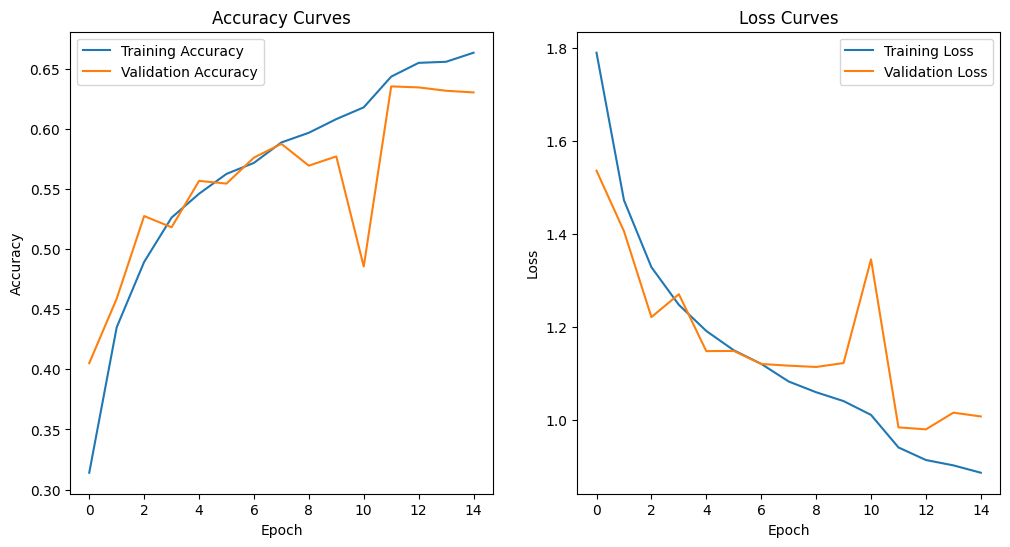

In [10]:
validation_accuracy = evaluation[1]
validation_loss = evaluation[0]

print(f"Validation Accuracy: {validation_accuracy}")
print(f"Validation Loss: {validation_loss}")

# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.show()

In [11]:
model_json=model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)